In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import scipy
import scipy.stats

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2022-07-19 23:32:20.688836: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-19 23:32:20.688880: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.9.1


## Load Data

In [3]:
featFileName = "../Data/features_combined.csv"
batch_pd = pd.read_csv(featFileName, index_col=False)

In [4]:
bat_info = batch_pd.loc[:,'policy':'cycle_life']
bat_info

,policy,barcode,cycle_life
0,3_6C-80PER_3_6C,???,1189.0
1,3_6C-80PER_3_6C,???,1178.0
2,3_6C-80PER_3_6C,???,1176.0
3,4C-80PER_4C,???,1225.0
4,4C-80PER_4C,???,1226.0
...,...,...,...
75,6C_31PER_4_25C,???,462.0
76,6C_40PER_4C,???,457.0
77,6C_4PER_4_75C,???,487.0
78,6C_52PER_3_5C,???,429.0


In [5]:
feat = batch_pd.drop(['policy','barcode','cycle_life','QDiffLinVar'], axis=1).to_numpy()
feat

array([[ 1.071,  0.468,  1.076, ...,  1.091,  0.   ,  1.072],
       [ 1.075,  0.009,  1.081, ...,  1.081, -0.   ,  1.085],
       [ 1.08 ,  0.008,  1.085, ...,  1.085, -0.   ,  1.089],
       ...,
       [ 1.07 ,  0.005,  1.073, ...,  1.075, -0.   ,  1.081],
       [ 1.073,  0.007,  1.08 , ...,  1.078, -0.   ,  1.081],
       [ 1.042,  0.008,  1.047, ...,  1.049, -0.   ,  1.055]])

In [6]:
# quoted: "data fix"
feat[0,9] = 1.692e-5;
feat[0,10] = 1.0750;

feat[14,1] = 0.00397;
feat[14,9] = -4.8296e-5;
feat[14,10] = 1.0705;

In [7]:
fast_charge_indices = bat_info['policy'].str.match("^[5-8].*C")
slow_charge_feat = feat[~fast_charge_indices]
slow_charge_label = bat_info["cycle_life"][~fast_charge_indices]
fast_charge_feat = feat[fast_charge_indices]
fast_charge_label = bat_info["cycle_life"][fast_charge_indices]

In [8]:
feat_train = slow_charge_feat[0::2]
feat_test = slow_charge_feat[1::2]
label_train = slow_charge_label[0::2]
label_test = slow_charge_label[1::2]

In [9]:
# scale data
feat_train_scaled = scipy.stats.zscore(feat_train)
feat_test_scaled = scipy.stats.zmap(feat_test, feat_train)

## Load Model
Load the 'base' model trained on 'fast charging' data subset.

In [11]:
discharge_model_fast = keras.models.load_model('../discharge_model/saved_model/DischargeModelFastTF')
discharge_model_fast.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 14        
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


2022-07-19 23:32:22.924446: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-07-19 23:32:22.924493: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: starlight-desktop
2022-07-19 23:32:22.924506: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: starlight-desktop
2022-07-19 23:32:22.924630: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.73.5
2022-07-19 23:32:22.924667: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.73.5
2022-07-19 23:32:22.924680: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.73.5


Also load the 'base' model trained on 'normal charging' data subset, with the same structure.

In [11]:
discharge_model_norm = keras.models.load_model('../discharge_model/saved_model/DischargeModelNormTF')

## Evaluate Base Model

In [13]:
all_rmse = pd.DataFrame(
    np.full(4, np.nan),
    index=[
        "base model (fast charge)",
        "base model (norm charge)",
        "transfer model (layered)",
        "transfer model (fine-tuned only)"
    ],
    columns=["RMSE"]
)

In [15]:
all_rmse.at["base model (fast charge)", "RMSE"] = discharge_model_fast.evaluate(
    scipy.stats.zmap(fast_charge_feat[1::2], fast_charge_feat[0::2]),
    fast_charge_label[1::2],
    verbose=0
) ** 0.5
all_rmse.at["base model (norm charge)", "RMSE"] = discharge_model_norm.evaluate(
    scipy.stats.zmap(slow_charge_feat[1::2], slow_charge_feat[0::2]),
    slow_charge_label[1::2],
    verbose=0
) ** 0.5
all_rmse

,RMSE
base model (fast charge),85.076781
base model (norm charge),266.750278
transfer model,NaN
transfer model (fine-tuned only),NaN


## Transfer Learning (Layering Method)

Freeze base model weights to preserve knowledge learned from base model training, so only the transformer is trained

In [16]:
discharge_model_fast.trainable = False

### Build Model
Construct new model for transfer learning by adding a 13-node layer with weights initialized to Identity function.  
  
The expectation is that the new battery population still has *some* similarities to the base training population and any differences are just due to a difference in the population mean and variance.  
  
Therefore, an Identity function that passes the 13 features through unchanged is a good starting point, and as training progresses the layer will learn to apply a transform on the input features to match the feature population that the base model was trained to expect.

In [17]:
transfer_model = keras.models.Sequential([
    layers.Dense(units=13, kernel_initializer=keras.initializers.Identity()),
    discharge_model_fast
])
transfer_model(feat_train_scaled)
transfer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (15, 13)                  182       
                                                                 
 sequential (Sequential)     (None, 1)                 14        
                                                                 
Total params: 196
Trainable params: 182
Non-trainable params: 14
_________________________________________________________________


In [18]:
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error')

In [19]:
# check pre-training loss identical to base model
transfer_model.evaluate(
    feat_test_scaled,
    label_test,
    verbose=0
) ** 0.5

170.57145451027262

### Train Model
Train the transfer learning model for 50 epochs.  
50 may seem quick, but adding any more epochs only seems to increase overfitting (measured by observing the divergence of test-set RMSE from training-set RMSE).

In [20]:
history = transfer_model.fit(
    feat_train_scaled,
    label_train,
    epochs=50,
    validation_data=(
        feat_test_scaled,
        label_test
    ),
    verbose=0
)

In [21]:
def plot_loss(history, ylims = [50, 300]):
    plt.plot(np.sqrt(history.history['loss']), label='loss')
    plt.plot(np.sqrt(history.history['val_loss']), label='val_loss')
    plt.ylim(ylims)
    plt.xlabel('Epoch')
    plt.ylabel('Error [cycles]')
    plt.legend()
    plt.grid(True)
    plt.show()

Graph of accuracy measured in RMSE over epochs of training.  
`loss` is the training set accuracy, `val_loss` is the test set accuracy.

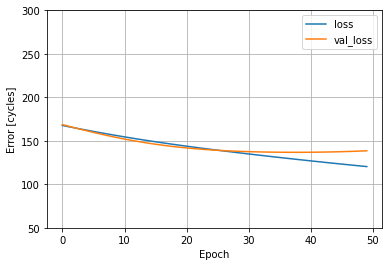

In [22]:
plot_loss(history)

In [23]:
hist = pd.DataFrame(history.history)
hist = hist.pow(0.5) # Power 1/2 is the same as square root
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
45,123.224389,137.535883,45
46,122.503520,137.746349,46
47,121.789666,137.982272,47
48,121.082782,138.242844,48
49,120.382849,138.527080,49


### Evaluate Model

In [ ]:
def plot_prediction(y_train_pred, y_test_pred, y_train_actual, y_test_actual, figure_name):
    plt.figure(figure_name, figsize=(5,5), dpi=100, facecolor='w', edgecolor='k')
    plt.axes(aspect='equal')
    plt.scatter(y_train_pred, y_train_actual, label='Predictions (train)')
    plt.scatter(y_test_pred, y_test_actual, label='Predictions (test)')
    lims = [0, 2000]
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot(lims, lims, 'k', )
    plt.xlabel('Predicted Cycle life')
    plt.ylabel('Actual Cycle life')
    plt.legend()
    plt.show()

Graph to show the distance of predictions from perfection. Black line is the line of exact match between prediction and actual cycle life; above the line is an underestimation, below the line is an overestimation.

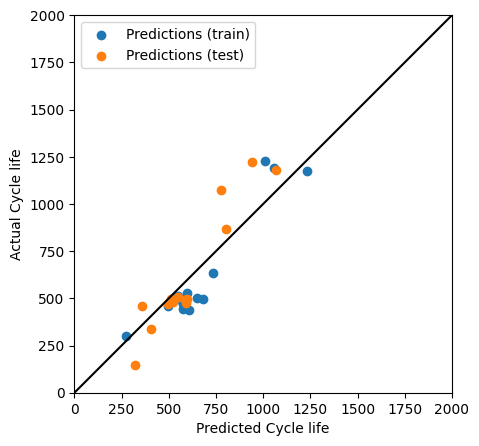

In [22]:
plot_prediction(
    transfer_model(feat_train_scaled),
    transfer_model(feat_test_scaled),
    label_train,
    label_test,
    "TransferModelLayeredPrediction"
)

In [24]:
# Train set RMSE
# Power 1/2 is the same as square root
# (TensorFlow configured to use MSE, so root must be done manually)
transfer_model.evaluate(
    feat_train_scaled,
    label_train, verbose=0) ** 0.5

119.68977641438303

In [25]:
all_rmse.at["transfer model (layered)", "RMSE"] = transfer_model.evaluate(
    feat_test_scaled,
    label_test, verbose=0) ** 0.5
all_rmse

,RMSE
base model (fast charge),106.944084
base model (norm charge),131.840302
133.829883,transfer model (layered)
transfer model (fine-tuned only),NaN


## Transfer Learning (Fine Tuning Only)
Just train the base model again on the 'normal charging' dataset to fine tune the weights learned from 'fast charging' and see how it's performance compares with layering method.

Unfreeze base model weights to allow fine tuning.

In [26]:
discharge_model_fast.trainable = True

### Train Model
Train the model for 1000 epochs, which is about just before it begins to overfit.

In [27]:
history = discharge_model_fast.fit(
    feat_train_scaled,
    label_train,
    epochs=1000,
    validation_data=(
        feat_test_scaled,
        label_test
    ),
    verbose=0
)

Graph of accuracy measured in RMSE over epochs of training.  
`loss` is the training set accuracy, `val_loss` is the test set accuracy.

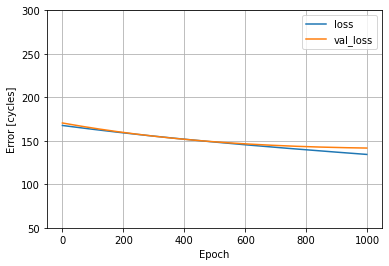

In [28]:
plot_loss(history)

### Evaluate Model

Graph to show the distance of predictions from perfection. Same method of representation as previously explained.

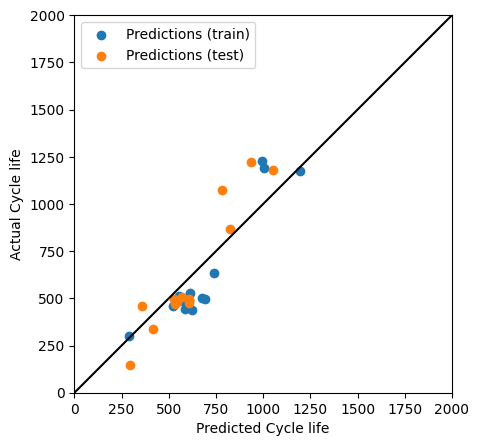

In [29]:
plot_prediction(
    discharge_model_fast(feat_train_scaled),
    discharge_model_fast(feat_test_scaled),
    label_train,
    label_test,
    "TransferModelFineTunedPrediction"
)

In [30]:
# Train set RMSE
discharge_model_fast.evaluate(
    feat_train_scaled,
    label_train, verbose=0) ** 0.5

134.33623714164023

In [36]:
# Two decimal places for easier viewing
pd.options.display.float_format = "{:.2f}".format

In [32]:
all_rmse.at["transfer model (fine-tuned only)", "RMSE"] = discharge_model_fast.evaluate(
    feat_test_scaled,
    label_test, verbose=0) ** 0.5
all_rmse

,RMSE
base model (fast charge),85.08
base model (norm charge),266.75
transfer model (layered),138.53
transfer model (fine-tuned only),141.69


## Layered Model's Weights
Weights of the 13-node layer of the layered transfer model, as requested.

In [56]:
weight_df = pd.DataFrame(
    transfer_model.layers[0].weights[0],
    columns=batch_pd.drop(['policy','barcode','cycle_life','QDiffLinVar'], axis=1).columns,
    index=["node {}".format(n) for n in range(1,14)]
)

In [38]:
bias_df = pd.DataFrame(
    transfer_model.layers[0].weights[1],
    columns=["bias"],
    index=["node {}".format(n) for n in range(1,14)]
)

In [39]:
pd.concat(
    [weight_df, bias_df], axis=1
).style.background_gradient(
    cmap ='Blues', axis=None
).set_properties(
    **{'background-color': 'lightblue'}, subset=['bias']
)

,QD2,QD(Max-2),QD100,QDiffMin,QDiffMean,QDiffVar,QDiffSkew,QDiffKurtosis,QDiffStart,R3Coef,R3Intercept,R1Coef,R1Intercept,bias
node 1,1.016682,-0.016682,0.016682,-0.016682,-0.016682,-0.016682,0.016682,-0.016682,-0.016682,-0.016682,0.016682,0.016682,0.000000,-0.048554
node 2,0.045723,0.954277,0.045723,-0.045723,-0.045723,-0.045723,0.045723,-0.045723,-0.045723,-0.045723,0.045723,0.045723,0.000000,0.048554
node 3,-0.003538,0.003538,0.996462,0.003538,0.003538,0.003538,-0.003538,0.003538,0.003538,0.003538,-0.003538,-0.003538,0.000000,-0.048554
node 4,-0.044698,0.044698,-0.044698,1.044698,0.044698,0.044698,-0.044698,0.044698,0.044698,0.044698,-0.044698,-0.044698,0.000000,0.048554
node 5,-0.044328,0.044328,-0.044328,0.044328,1.044328,0.044328,-0.044328,0.044328,0.044328,0.044328,-0.044328,-0.044328,0.000000,0.048554
node 6,-0.044513,0.044513,-0.044513,0.044513,0.044513,1.044513,-0.044513,0.044513,0.044513,0.044513,-0.044513,-0.044513,0.000000,0.048554
node 7,0.046226,-0.046226,0.046226,-0.046226,-0.046226,-0.046226,1.046226,-0.046226,-0.046226,-0.046226,0.046226,0.046226,0.000000,-0.048554
node 8,-0.037473,0.037473,-0.037473,0.037473,0.037473,0.037473,-0.037473,1.037473,0.037473,0.037473,-0.037473,-0.037473,0.000000,0.048554
node 9,-0.032809,0.032809,-0.032809,0.032809,0.032809,0.032809,-0.032809,0.032809,1.032809,0.032809,-0.032809,-0.032809,0.000000,0.048554
node 10,-0.001305,0.001305,-0.001305,0.001305,0.001305,0.001305,-0.001305,0.001305,0.001305,1.001305,-0.001305,-0.001305,0.000000,0.048554
